In [12]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import GridSearchCV

import tensorflow as tf
from tensorflow import keras

In [3]:
folder_path = '../data/clean/'
data = pd.read_csv(os.path.join(folder_path, 'X_train.csv'), index_col=0)
target = pd.read_csv(os.path.join(folder_path, 'Y_train.csv'), index_col=0)
prdtype = pd.read_csv('../data/prdtype.csv', index_col='prdtypecode')
target = prdtype.loc[target['prdtypecode'], 'prdtypedesignation']

In [4]:
data.head()

,designation,description,productid,imageid,language,designation_translated,description_translated
0,Olivia: Personalisiertes Notizbuch / 150 Seite...,NaN,3804725264,1263597046,de,Olivia : Carnet personnalisé / 150 pages / gri...,NaN
1,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN,436067568,1008141237,fr,Journal Des Arts (Le) N° 133 Du 28/09/2001 - L...,NaN
2,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...,201115110,938777978,fr,Grand Stylet Ergonomique Bleu Gamepad Nintendo...,PILOT STYLE Touch Pen de marque Speedlink est ...
3,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN,50418756,457047496,en,Peluche Donald - Europe - Disneyland 2000 (Mar...,NaN
4,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...,278535884,1077757786,fr,La Guerre Des Tuques,Luc a des idées de grandeur. Il veut organiser...


## Tokenize translated text

In [64]:
#tokenize multiple columns
from nltk.tokenize import word_tokenize

colnames = ['designation_translated', 'description_translated'] #['designation', 'description']#
merged_txt = data[colnames].apply(lambda row: ' '.join(s for s in row if isinstance(s, str)), axis=1)
data['tokens'] = merged_txt.str.lower().apply(lambda x: word_tokenize(x, language='french'))

## Load stopwords from NLTK

In [65]:
from nltk.corpus import stopwords

stop_words = set(stopwords.words('french'))
new_stop_words = [",", ".", "``", "@", "*", "(", ")", "...", "!", "?", "-", "_", ">", "<", ":", "/", "=", "--", "©", "~", ";", "\\", "\\\\"]
stop_words.update(new_stop_words)

## Remove stopwords from tokens

In [7]:
def remove_stopwords(words, stopwords):
    #remove words in stopwords
    words_filtered = [word for word in words if word not in stopwords]
    return words_filtered

def remove_token_duplicates(words):
    #remove duplicated tokens, keeping the same order
    wordset = set()
    words_filtered = [wordset.add(word) or word for word in words if word not in wordset]
    return words_filtered

In [8]:
#Removing stop words
data['tokens'] = data['tokens'].apply(lambda x: remove_stopwords(x, stop_words))

In [ ]:
#Removing duplicated tokens
data['tokens'] = data['tokens'].apply(lambda x: remove_token_duplicates(x))

In [67]:
#Converting list of tokens to string
data['tokens'] = data['tokens'].apply(lambda x:  ' '.join(x))

## Further cleaning with Regex?

In [ ]:
#import re

#remove words shorter than 4 characters
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b\w{1,2}\b(?!°)", ' ', x))

#remove numbers
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"[0-9]+", ' ', x))

#remove any word that has no vowel
#data['tokens'] = data['tokens'].apply(lambda x:  re.sub(r"\b(?![^aeiouyáéíóúàèìòùâêîôûäëïöü])[^\s]+\b", ' ', x))

#removing extra spaces
#data['tokens'] = data['tokens'].apply(lambda x: ' '.join(x.split()))

## Function to plot results

In [47]:
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import linkage, leaves_list

def plot_classification_results(y_true, y_pred, index=None):
    #Print evaluation metrics
    print(classification_report(y_true, y_pred))
    
    #Build confusion matrix
    conf_mat = round(pd.crosstab(y_true, y_pred, rownames=['Classes reelles'], colnames=['Classes predites'], normalize='columns')*100)

    #in case labels are encoded, update with the original lables provided
    if index is not None:
        conf_mat.index = index
        conf_mat.columns = index
        
    #hierarchical clustering to find optimal order of labels
    Z = linkage(conf_mat, 'ward')
    order = leaves_list(Z)
    conf_mat = conf_mat.iloc[order, order]

    #plot confusion matrix as heatmap
    plt.figure(figsize=(15,12))
    sns.heatmap(conf_mat, annot=round(conf_mat,12), center=50, cmap=sns.color_palette('rocket',  as_cmap=True))
    plt.show()
    
    return plt

## Creating train and test sets

In [68]:
from sklearn.model_selection import train_test_split

#Creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(data['tokens'], target, test_size=0.2, random_state=123, stratify=target)

## Vectorization layer

<Axes: >

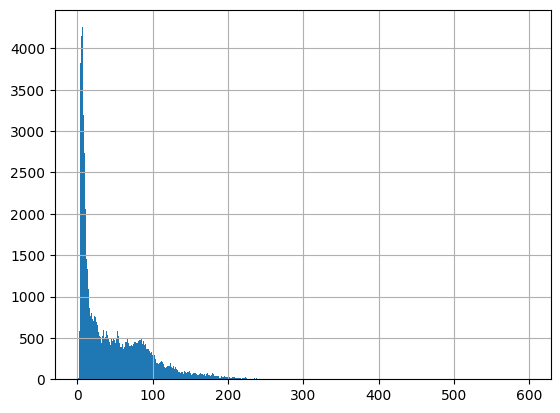

In [31]:
data['tokens'].str.split().apply(len).hist(bins=range(0, 600, 1))

In [25]:
data['tokens'][data['tokens'].str.split().apply(len)==1]
data['designation'][data['tokens'].str.split().apply(len)==1]

11097                      Poèmes À Vous !
16776                    Le Son De L'image
23032               Dans La Chaleur De été
37980               Tell Me About Yourself
45023                    Tu Es Une Légende
56447    Les Indésirables Les Indésirables
64775           Tylomon - Digimon - Bo-204
67342            Moi Vous Me Connaissez ? 
71047                   Je Suis Une Île...
72649                        K A M B U T I
80487                      Nadau ! Nadau !
Name: designation, dtype: object

In [32]:

from sklearn.preprocessing import LabelEncoder

#Encoding classes as integers
encoder = LabelEncoder()
y_train_class = encoder.fit_transform(y_train)
y_test_class = encoder.transform(y_test)

In [88]:
from keras.models import Sequential
from keras.layers import Input, TextVectorization, Embedding, Flatten, Dense, Conv1D, Conv2D, Dropout, MaxPooling1D, Reshape
from keras.metrics import F1Score

#Size of vocabulary
max_len = 600 #max length of senetnces in tokens
max_tok = 140000 #max number of different tokens
outvec_size = 300
n_class = len(np.unique(y_train_class)) #number of classes for classification layer
f1_score = F1Score(average='weighted', threshold=None, name='f1_score', dtype=None) #Can't yet make that one work

#Building simple dense model with embedding
model = Sequential()
model.add(Input(shape=(1,), dtype=tf.string))
model.add(TextVectorization(max_tokens=max_tok, output_mode='int', output_sequence_length=max_len, standardize="lower_and_strip_punctuation", split='whitespace'))
model.add(Embedding(input_dim=max_tok, output_dim=outvec_size, input_length=max_len))

#model.add(Reshape((max_len, 1, outvec_size)))
#model.add(Conv2D(filters=64, kernel_size=(3, 1), activation='relu'))

#model.add(Conv1D(outvec_size, 5, activation='relu')) #Conv1D applies across the sequences
#model.add(MaxPooling1D(3))
#model.add(Conv1D(outvec_size//2, 7, activation='relu'))

model.add(Dropout(rate=0.2))
model.add(Flatten())
model.add(Dense(units=128, activation='relu'))
#model.add(Dropout(rate=0.2))
#model.add(Dense(units=64, activation='relu'))
model.add(Dense(units=n_class, activation='softmax'))

#Creating the vocabulary for the tokenizer before training
model.layers[0].adapt(X_train)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [89]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 text_vectorization_8 (Text  (None, 600)               0         
 Vectorization)                                                  
                                                                 
 embedding_13 (Embedding)    (None, 600, 300)          42000000  
                                                                 
 dropout_4 (Dropout)         (None, 600, 300)          0         
                                                                 
 flatten_12 (Flatten)        (None, 180000)            0         
                                                                 
 dense_25 (Dense)            (None, 128)               23040128  
                                                                 
 dense_26 (Dense)            (None, 27)                3483      
                                                     

In [90]:
history = model.fit(X_train, y_train_class, epochs=5, batch_size=64, validation_split=0.1)

Epoch 1/5
166/956 [====>.........................] - ETA: 2:53 - loss: 2.6776 - accuracy: 0.2724

531/531 [==============================] - 6s 11ms/step
              precision    recall  f1-score   support

           0       0.82      0.78      0.80       336
           1       0.85      0.62      0.72       165
           2       0.88      0.89      0.89       791
           3       0.89      0.72      0.79       161
           4       0.96      0.78      0.86       166
           5       0.54      0.59      0.57       153
           6       0.79      0.67      0.73       534
           7       0.93      0.90      0.92       998
           8       0.53      0.51      0.52       414
           9       0.84      0.86      0.85      1009
          10       0.58      0.72      0.64       502
          11       0.80      0.70      0.75       284
          12       0.98      0.98      0.98       174
          13       0.66      0.59      0.62       974
          14       0.88      0.91      0.89       861
          15       0.77      0.74      0.75       955
          16       0.66  

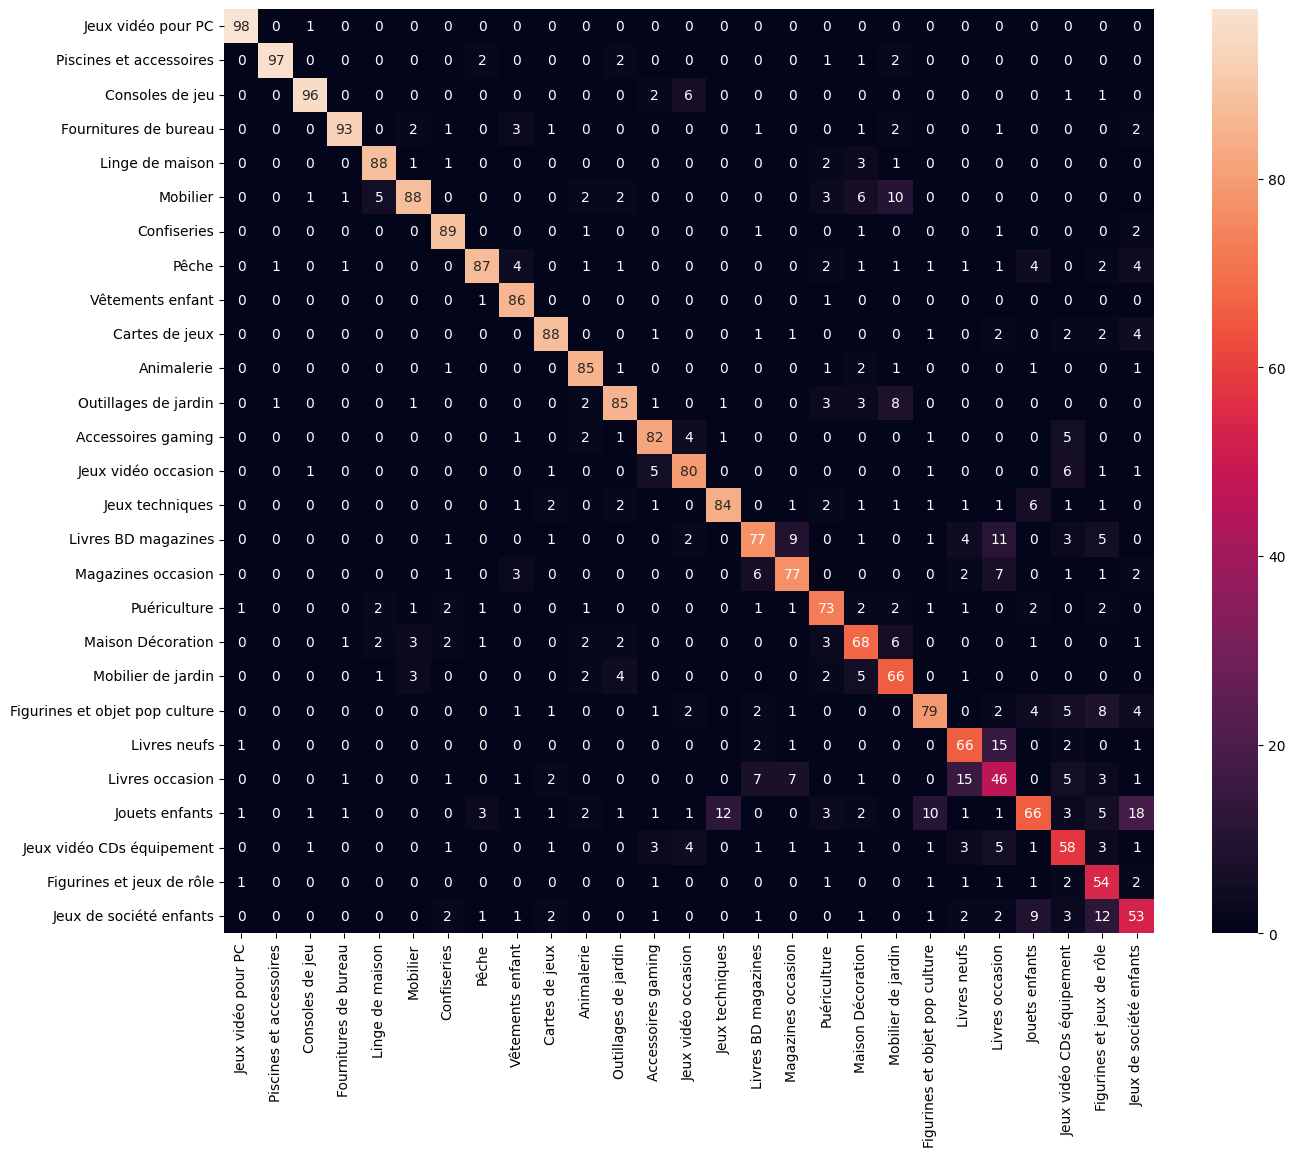

<module 'matplotlib.pyplot' from 'c:\\Users\\justj\\.conda\\envs\\Rakuten\\Lib\\site-packages\\matplotlib\\pyplot.py'>

In [84]:
test_pred = model.predict(X_test)
test_pred_class = np.argmax(test_pred, axis=1)
plot_classification_results(y_test_class, test_pred_class, index=encoder.classes_)